### TRAIN the classifier

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-12-04 10:34:20.786364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733304860.864473    7881 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733304860.886112    7881 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 10:34:21.050510: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow_datasets as tfds
builder = tfds.folder_dataset.ImageFolder('../02-data/02-classifier/')
print(builder.info)
raw_train = builder.as_dataset(split='train', shuffle_files=True)
raw_test = builder.as_dataset(split='test', shuffle_files=True)
raw_valid = builder.as_dataset(split='valid', shuffle_files=True)

2024-12-04 10:34:24.840015: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_dir='/home/pablo/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=80, num_shards=1>,
        'train': <SplitInfo num_examples=1650, num_shards=1>,
        'valid': <SplitInfo num_examples=159, num_shards=1>,
    },
    citation="""""",
)


I0000 00:00:1733304865.546285    7881 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3487 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


2024-12-04 10:35:05.004736: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


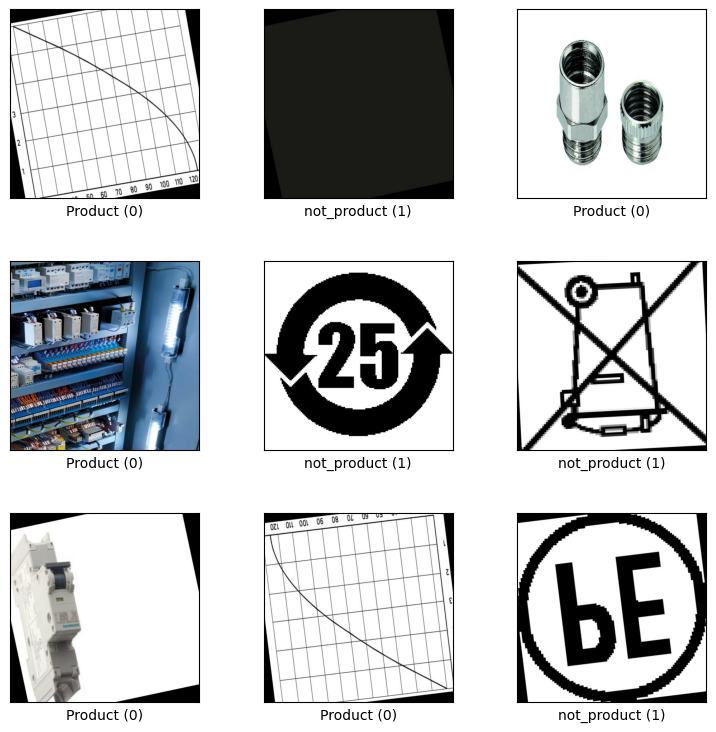

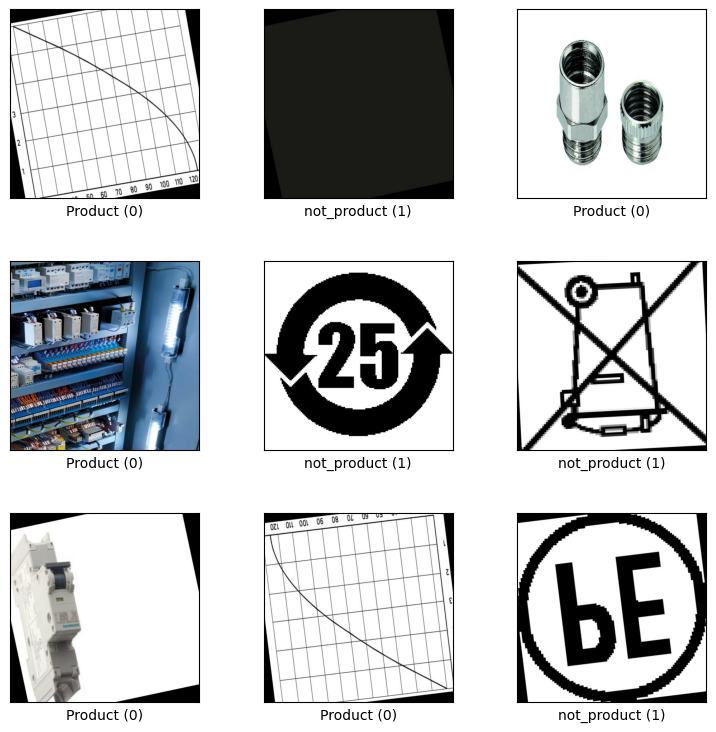

In [3]:
tfds.show_examples(raw_train, builder.info)

In [4]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(pair):
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [5]:
train = raw_train.map(format_example)
validation = raw_valid.map(format_example)
test = raw_test.map(format_example)

In [6]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [9]:
#train = raw_train
#validation = raw_valid
#test = raw_test

In [7]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [8]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

2024-12-04 10:35:43.424373: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


TensorShape([32, 160, 160, 3])

In [9]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [10]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

E0000 00:00:1733304950.238139    7881 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2024-12-04 10:35:50.238925: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at conv_ops_impl.h:1204 : INVALID_ARGUMENT: No DNN in stream executor.


InvalidArgumentError: Exception encountered when calling Conv2D.call().

[1m{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} No DNN in stream executor. [Op:Conv2D][0m

Arguments received by Conv2D.call():
  • inputs=tf.Tensor(shape=(32, 160, 160, 3), dtype=float32)

----------

## API calls to the roboflow model (10k/month limit)

In [11]:
# import the inference-sdk
from inference_sdk import InferenceHTTPClient

# initialize the client
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="7NCLqGWcsjLaJRUeHZdw"
)

img_path = "/media/pablo/windows_files/00 - Master/05 - Research&Thesis/R2-Research_Internship_2/02-data/00-testing/7958A_techdata_page1_img5.png"
# infer on a local image
result = CLIENT.infer(img_path, model_id="filter-images/1")

predictions = result['predictions']


# Find the prediction with the highest confidence
highest_confidence_prediction = max(predictions, key=lambda x: x['confidence'])

# Extract the class_id
highest_confidence_class_id = highest_confidence_prediction['class_id']

if(highest_confidence_class_id==1):
    print("Product!")
else:
    print("Not Product!")

Product!


In [4]:
import os

def image_to_llm(image_path, file_handle):
    """
    Calls the model to process the image and writes the result into the file handle.
    """
    # Simulate calling the Llama model and getting the text description
    # Replace the line below with your actual model call
    text_description = "hello this is the fooking test"

    # Write the result to the provided file handle
    file_handle.write(f"{text_description}\n\n")

    ## CALL LlaVa -> get text description2
    ## CALL Florence -> get text description3

    # Call Llama -> concatenate all descriptions

    return file_handle

def process_images(txt_path,function):
    """
    Processes image files in labeled folders, applying a given function to each image.

    Args:
        txt_path (str): Path to the root directory containing label folders.
    """
    # Get a list of labels (folders) in the root directory
    folders = os.listdir(txt_path)

    # Wrap the label loop with tqdm to show progress
    for folder in folders:
        folder_path = os.path.join(txt_path, folder)

        # Traverse all subdirectories and files
        for root, _, files in os.walk(folder_path):
            output_file = None  # Initialize output file handle
            try:
                for file in files:
                    # Check if the file is an image
                    if file.lower().endswith(('.jpeg', '.jpg', '.png')):
                        image_path = os.path.join(root, file)

                        # Create the output file if not already created for this subdirectory
                        if output_file is None:
                            output_file_path = os.path.join(root, f"image_to_txt")
                            output_file = open(output_file_path, "w")  # Open the file in write mode

                        # Call the processing function and write its result to the output file
                        processed_content = function(image_path,output_file)
            finally:
                # Ensure the output file is closed properly
                if output_file:
                    output_file.close()
                    
                    



txt_path = "../02-data/txts/0-testing/"
destination_path = "../02-data/0-testing/images"

llama_model = "qresearch/llama-3.1-8B-vision-378"
model,tokenizer = 0,1
max_new_tokens = 200
prompt = "USER: <image>\nDescribe in a tecnhical manner the elements in the image\nASSISTANT:"
process_images(txt_path,image_to_llm)